In [1]:
import pandas as pd 
import numpy as np 
import sys
import os

# Load other functions
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../scripts'))

from Load_data import CSVDataloader, get_file_path
from EDA import univariate_analysis1, bivariate_analysis1


In [2]:
# Load credit data
credit_path = get_file_path("credit")
credit_loader = CSVDataloader(credit_path)
df_credit = credit_loader.load_data()

# Load fraud data
fraud_path = get_file_path("fraud")
fraud_loader = CSVDataloader(fraud_path)
df_fraud = fraud_loader.load_data()

# Load IPAddress data
IPAddress_path = get_file_path("IpAddresss")
IPAddress_loader = CSVDataloader(IPAddress_path)
df_Address = IPAddress_loader.load_data()


In [3]:
# Load credit dataset
df_credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Load credit dataset
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2/24/2015 22:55,4/18/2015 2:47,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,6/7/2015 20:39,6/8/2015 1:38,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,1/1/2015 18:52,1/1/2015 18:52,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,4/28/2015 21:13,5/4/2015 13:54,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,7/21/2015 7:09,9/9/2015 18:40,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
df_Address.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Data Analysis and Preprocessing

In [7]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [8]:
df_fraud.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [27]:
print("\nMissing values in fraud dataset:")
df_fraud.isna().sum()


Missing values in fraud dataset:


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [26]:
# Check for missing values in IP address dataset
print("\nMissing values in IP address dataset:")
print(df_Address.isnull().sum())



Missing values in IP address dataset:
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64


In [28]:
# Check for duplicates in fraud dataset
print("\nDuplicate rows in fraud dataset before cleaning:", df_fraud.duplicated().sum())


Duplicate rows in fraud dataset before cleaning: 0


In [29]:
# Check for duplicates in IP address dataset
print("\nDuplicate rows in IP address dataset before cleaning:", df_Address.duplicated().sum())


Duplicate rows in IP address dataset before cleaning: 0


#### Correct Data Types
df_fraud['ip_address'] is currently a float64. Since IP addresses are stored as numeric IDs (likely converted from dotted format), I will convert it to integers.

In [30]:
# Check current data types
print("\nFraud dataset data types before correction:")
print(df_fraud.dtypes)


Fraud dataset data types before correction:
user_id            int64
signup_time       object
purchase_time     object
purchase_value     int64
device_id         object
source            object
browser           object
sex               object
age                int64
ip_address         int64
class              int64
dtype: object


In [11]:
# Convert ip_address from float to int
df_fraud['ip_address'] = df_fraud['ip_address'].astype('int64')

In [31]:
# Convert datetime columns in fraud dataset
df_fraud['signup_time'] = pd.to_datetime(df_fraud['signup_time'])
df_fraud['purchase_time'] = pd.to_datetime(df_fraud['purchase_time'])

In [32]:
# Convert class to boolean (since it's binary)
df_fraud['class'] = df_fraud['class'].astype(bool)

In [36]:
# Verify data types after conversion
print("\nFraud dataset data types after correction:")
print(df_fraud.dtypes)


Fraud dataset data types after correction:
user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address                 int64
class                       bool
dtype: object


In [34]:
print("\nIP address dataset data types before correction:")
print(df_Address.dtypes)


IP address dataset data types before correction:
lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object


In [35]:
# For IP address dataset, ensure numeric columns are correct
df_Address['lower_bound_ip_address'] = df_Address['lower_bound_ip_address'].astype('int64')
df_Address['upper_bound_ip_address'] = df_Address['upper_bound_ip_address'].astype('int64')
df_Address['country'] = df_Address['country'].astype('category')

In [37]:
print("\nIP address dataset data types after correction:")
print(df_Address.dtypes)


IP address dataset data types after correction:
lower_bound_ip_address       int64
upper_bound_ip_address       int64
country                   category
dtype: object


## Univariate analysis

Starting Univariate Analysis...


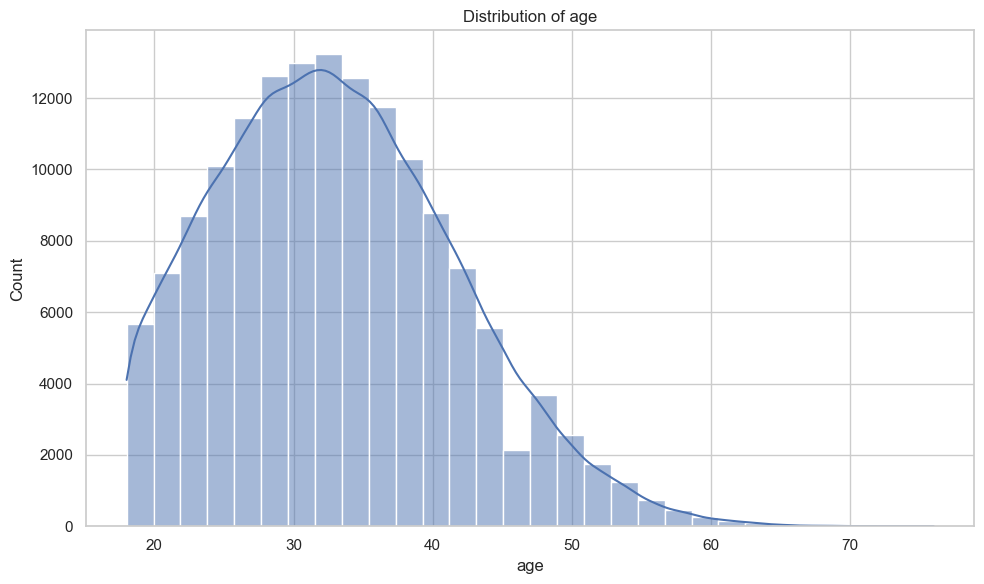

In [ ]:
print("Starting Univariate Analysis...")
univariate_analysis(df_fraud, "age")

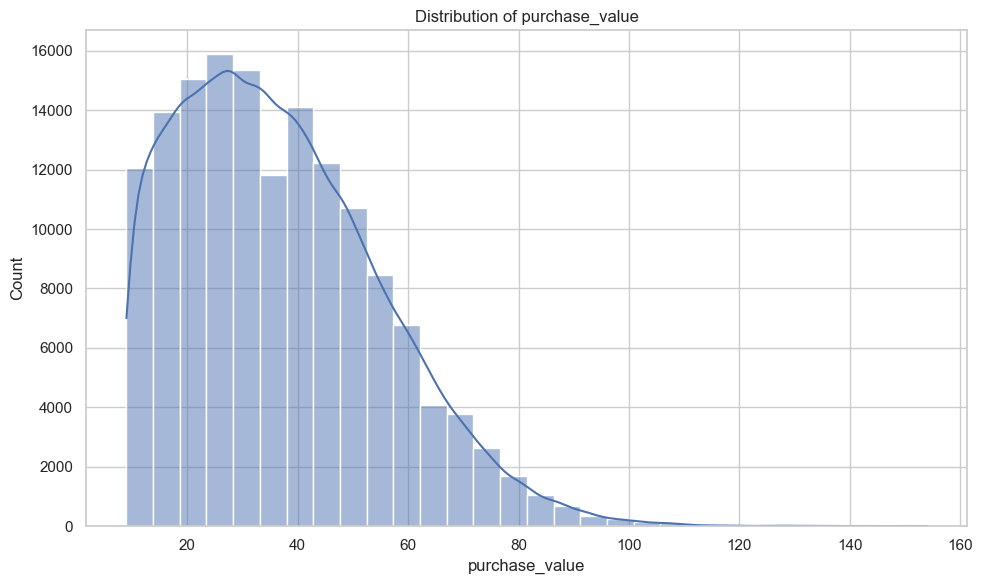

In [13]:
univariate_analysis(df_fraud, "purchase_value")

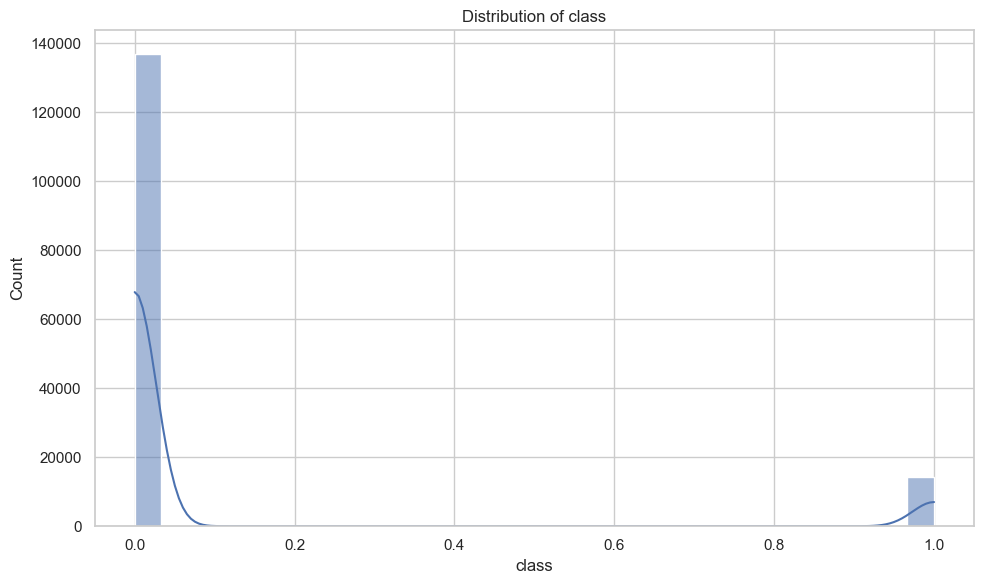

In [18]:
univariate_analysis(df_fraud, "class")

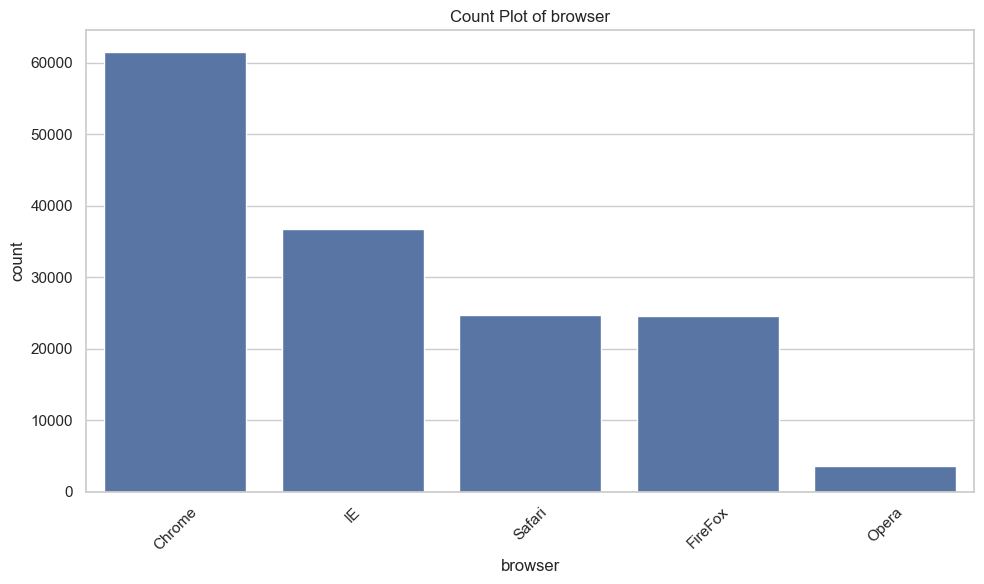

In [15]:
univariate_analysis(df_fraud, "browser")

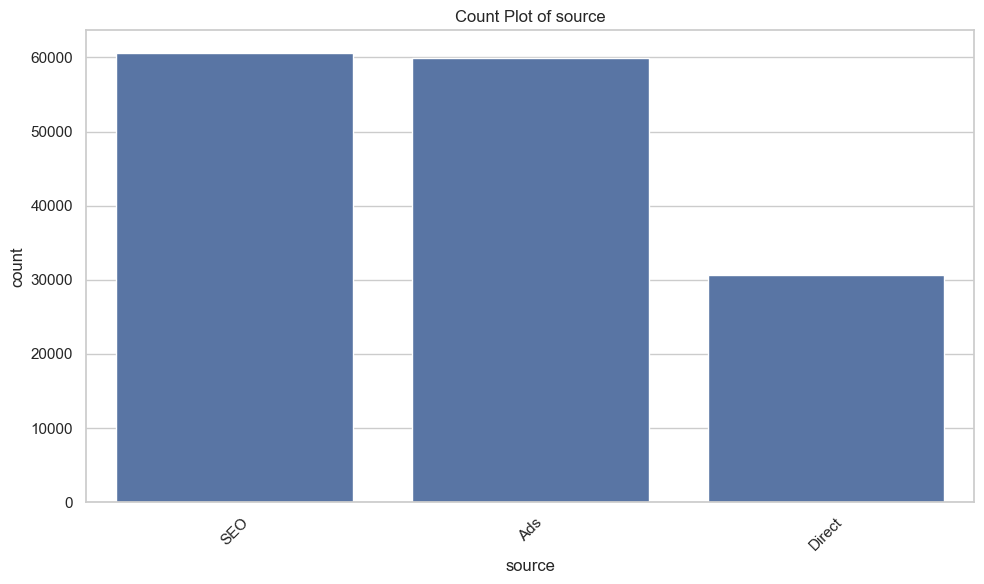

In [16]:
univariate_analysis(df_fraud, "source")

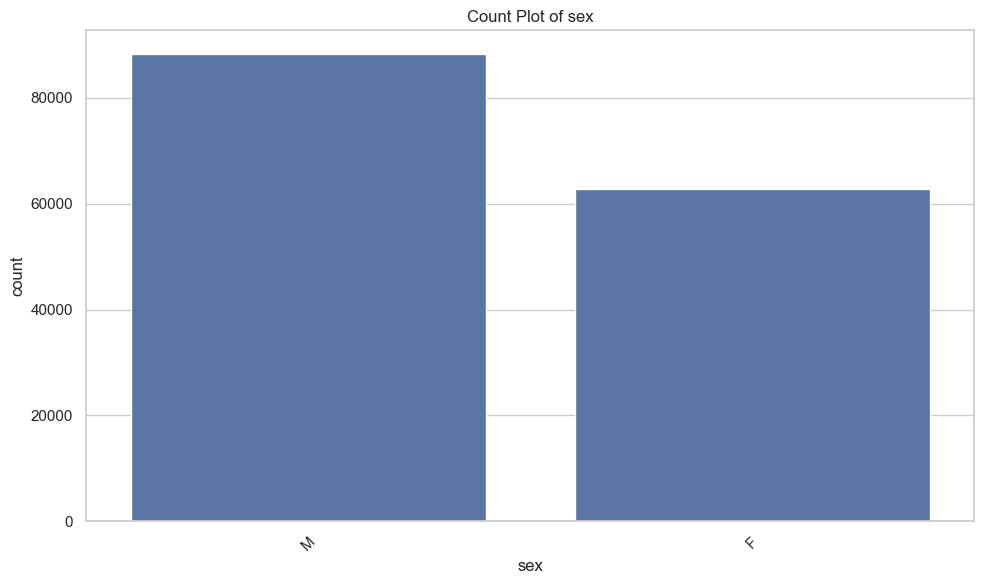

In [17]:
univariate_analysis(df_fraud, "sex")

## Bivariate analysis

Starting Bivariate Analysis...


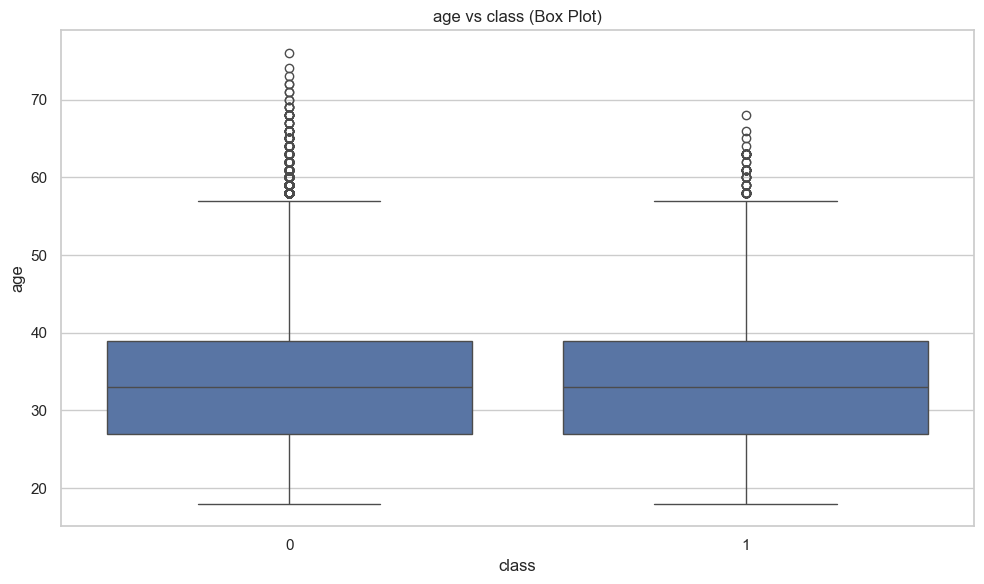

In [19]:
print("Starting Bivariate Analysis...")
bivariate_analysis(df_fraud, "age", "class")

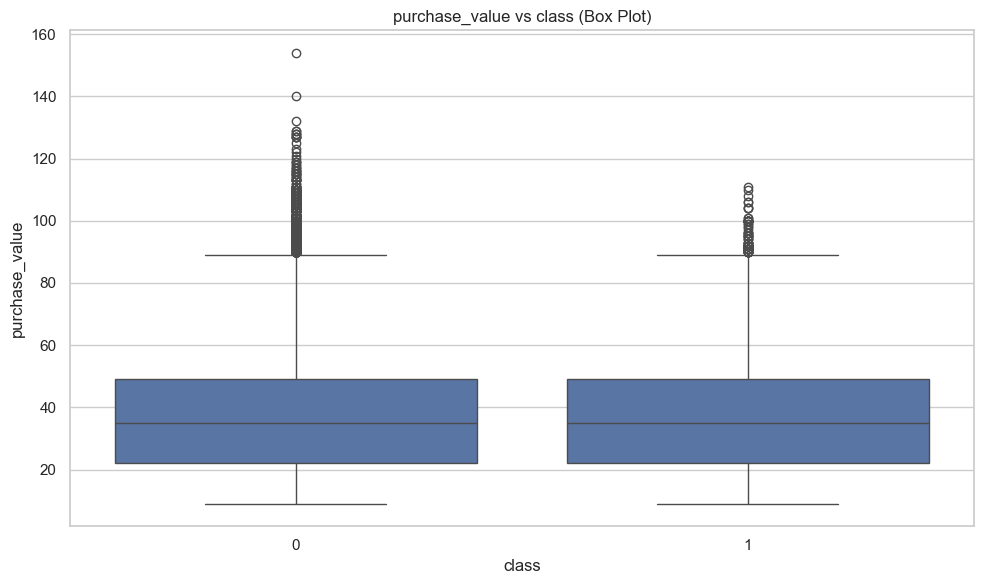

In [21]:
bivariate_analysis(df_fraud, "purchase_value", "class")

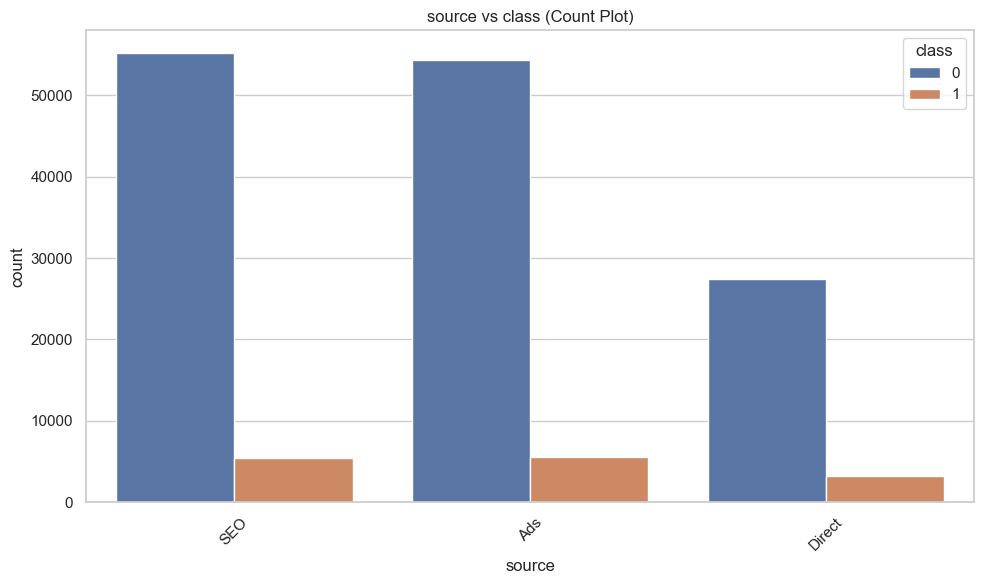

In [22]:
bivariate_analysis(df_fraud, "source", "class")

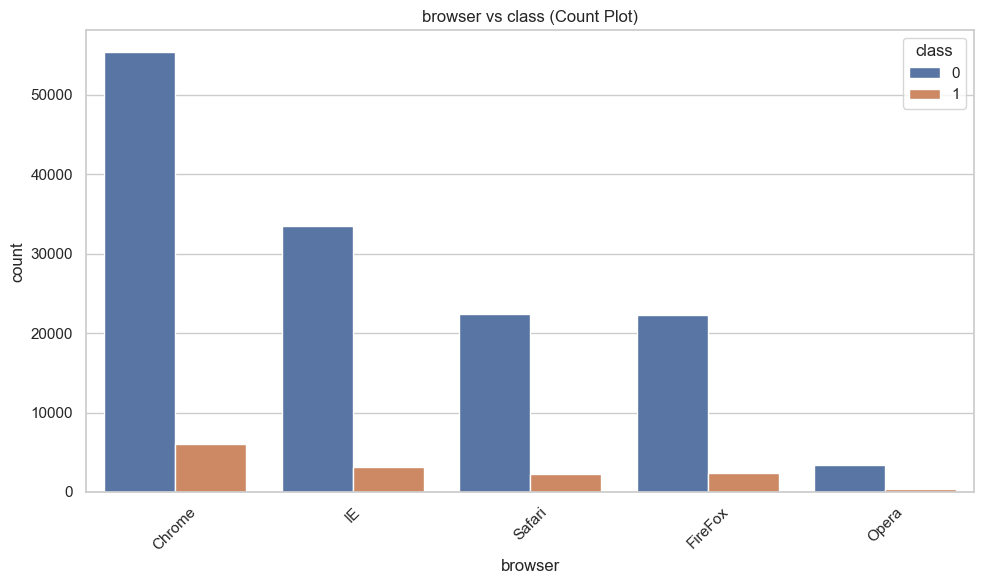

In [23]:
bivariate_analysis(df_fraud, "browser", "class")

### Merge Datasets for Geolocation Analysis

UNIVARIATE ANALYSIS RESULTS

Univariate Analysis for: user_id
Data type: int64
Unique values: 151112
Null values: 0

Numeric Statistics:
count    151112.000000
mean     200171.040970
std      115369.285024
min           2.000000
25%      100642.500000
50%      199958.000000
75%      300054.000000
max      400000.000000
Name: user_id, dtype: float64


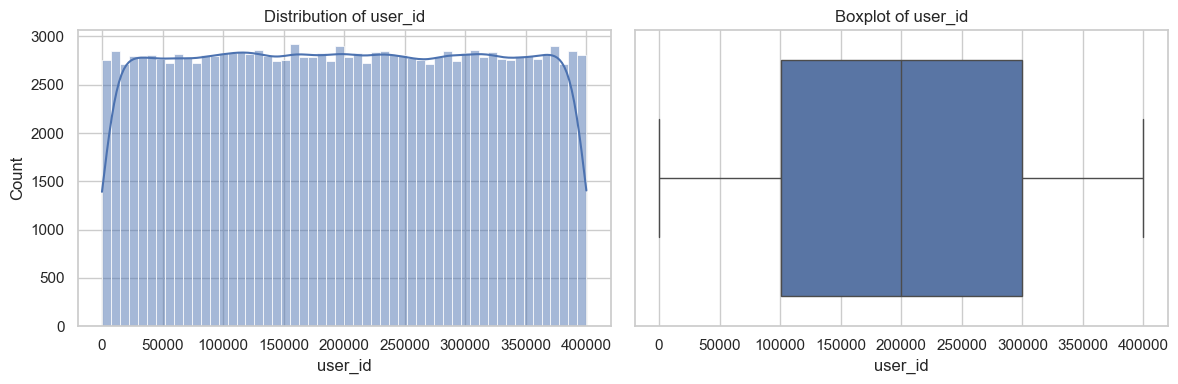


Univariate Analysis for: signup_time
Data type: object
Unique values: 135572
Null values: 0

Category Distribution (%):
signup_time
1/6/2015 12:10     0.019191
1/6/2015 12:53     0.014559
1/6/2015 6:33      0.013897
1/10/2015 23:23    0.013235
1/3/2015 10:47     0.013235
                     ...   
2/1/2015 1:06      0.000662
5/15/2015 3:52     0.000662
3/20/2015 0:31     0.000662
2/3/2015 0:48      0.000662
7/17/2015 5:48     0.000662
Name: proportion, Length: 135572, dtype: float64

Univariate Analysis for: purchase_time
Data type: object
Unique values: 121599
Null values: 0

Category Distribution (%):
purchase_time
1/6/2015 12:10     0.017868
1/6/2015 12:53     0.014559
1/3/2015 10:47     0.012573
1/7/2015 9:35      0.012573
1/3/2015 13:10     0.012573
                     ...   
5/25/2015 17:21    0.000662
8/27/2015 3:37     0.000662
9/9/2015 18:40     0.000662
6/8/2015 1:38      0.000662
4/18/2015 2:47     0.000662
Name: proportion, Length: 121599, dtype: float64

Univariate Anal

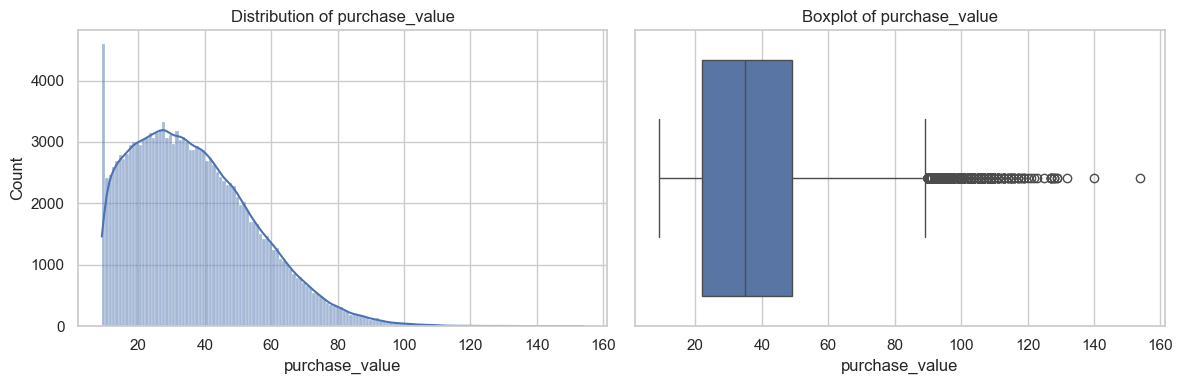


Univariate Analysis for: device_id
Data type: object
Unique values: 137956
Null values: 0

Category Distribution (%):
device_id
ITUMJCKWEYNDD    0.013235
CQTUVBYIWWWBC    0.013235
EQYVNEGOFLAWK    0.013235
NGQCKIADMZORL    0.013235
KIPFSCNUGOLDP    0.013235
                   ...   
UNUAVQXNWFBMO    0.000662
TGHVAWBMZRDHH    0.000662
WFIIFCPIOGMHT    0.000662
NWSVDOHYIOBDR    0.000662
KFZGQIWDIRLZB    0.000662
Name: proportion, Length: 137956, dtype: float64

Univariate Analysis for: source
Data type: object
Unique values: 3
Null values: 0

Category Distribution (%):
source
SEO       40.112632
Ads       39.626899
Direct    20.260469
Name: proportion, dtype: float64


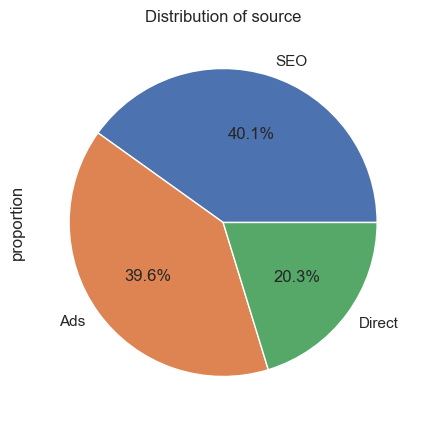


Univariate Analysis for: browser
Data type: object
Unique values: 5
Null values: 0

Category Distribution (%):
browser
Chrome     40.653290
IE         24.304489
Safari     16.323654
FireFox    16.285934
Opera       2.432633
Name: proportion, dtype: float64


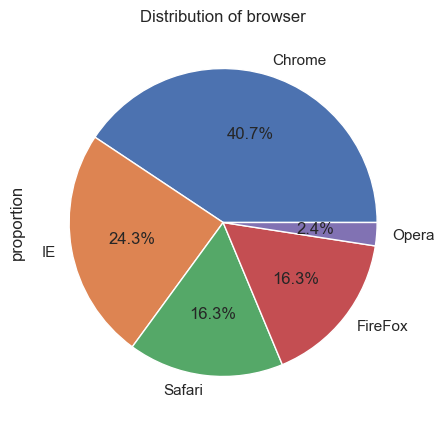


Univariate Analysis for: sex
Data type: object
Unique values: 2
Null values: 0

Category Distribution (%):
sex
M    58.428847
F    41.571153
Name: proportion, dtype: float64


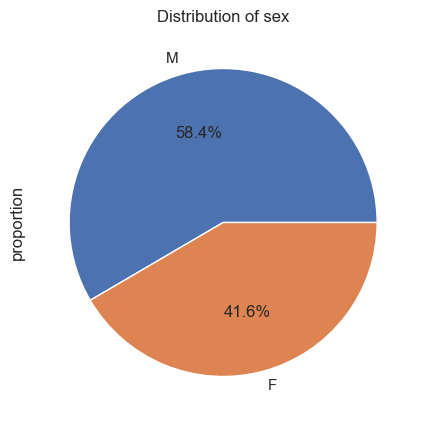


Univariate Analysis for: age
Data type: int64
Unique values: 58
Null values: 0

Numeric Statistics:
count    151112.000000
mean         33.140704
std           8.617733
min          18.000000
25%          27.000000
50%          33.000000
75%          39.000000
max          76.000000
Name: age, dtype: float64


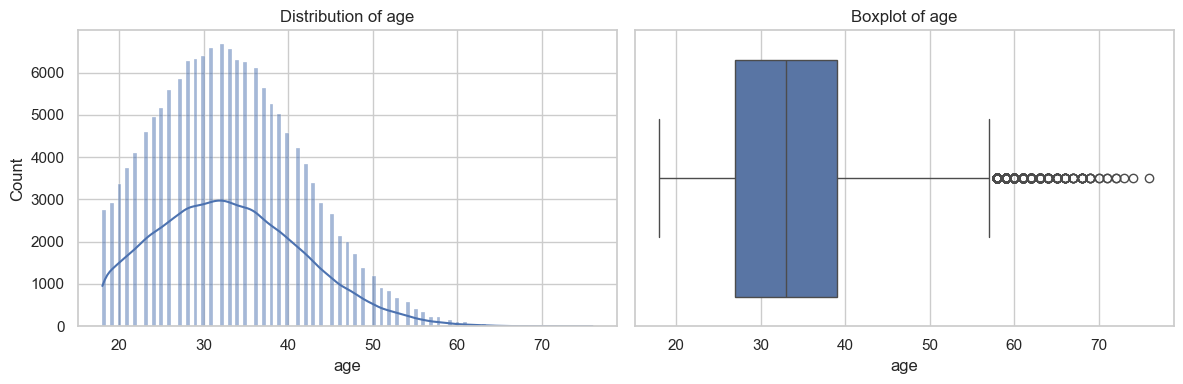


Univariate Analysis for: ip_address
Data type: float64
Unique values: 143511
Null values: 0

Numeric Statistics:
count    1.511120e+05
mean     2.152145e+09
std      1.248497e+09
min      5.209350e+04
25%      1.085934e+09
50%      2.154770e+09
75%      3.243258e+09
max      4.294850e+09
Name: ip_address, dtype: float64


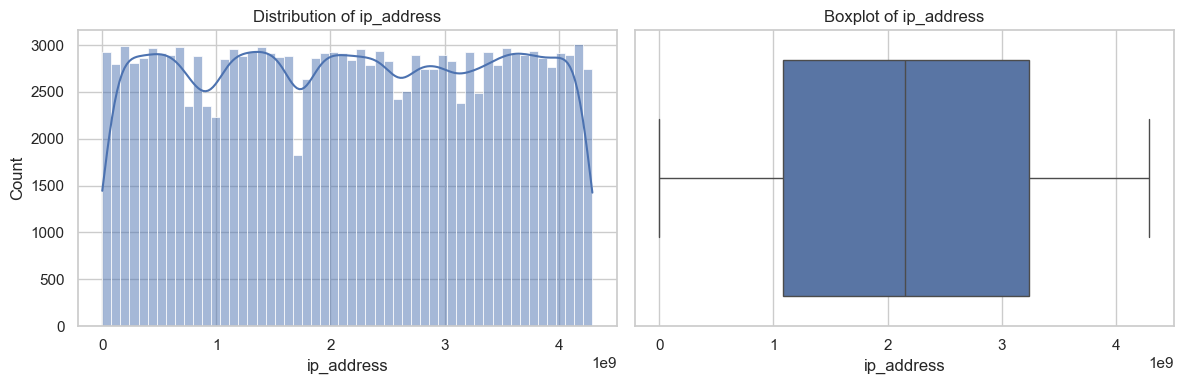


Univariate Analysis for: class
Data type: int64
Unique values: 2
Null values: 0

Numeric Statistics:
count    151112.000000
mean          0.093646
std           0.291336
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: class, dtype: float64


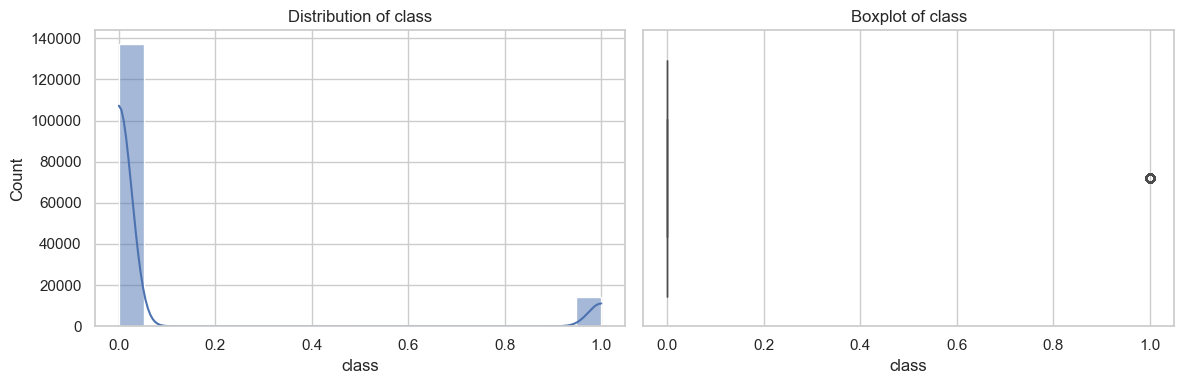

In [5]:
# Perform univariate analysis on all columns
print("UNIVARIATE ANALYSIS RESULTS")
uni_results = univariate_analysis1(df_fraud)




BIVARIATE ANALYSIS RESULTS

Bivariate Analysis with target: class

Analysis for: user_id vs class

Correlation with class: 0.00


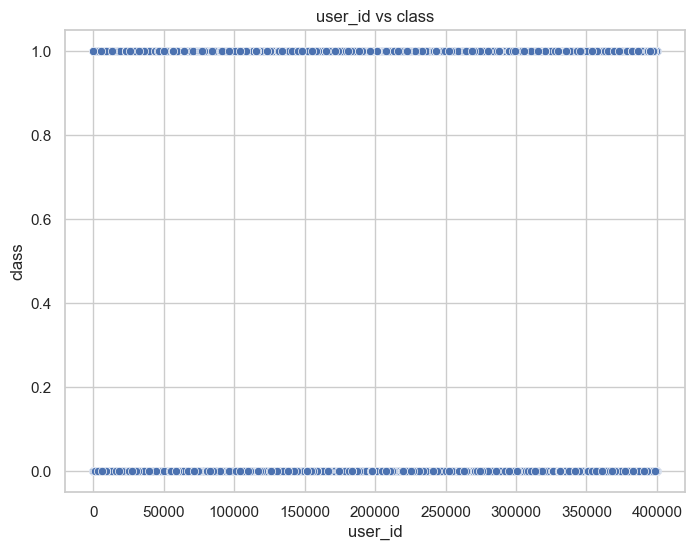


Analysis for: signup_time vs class

Analysis for: purchase_time vs class

Analysis for: purchase_value vs class

Correlation with class: 0.00


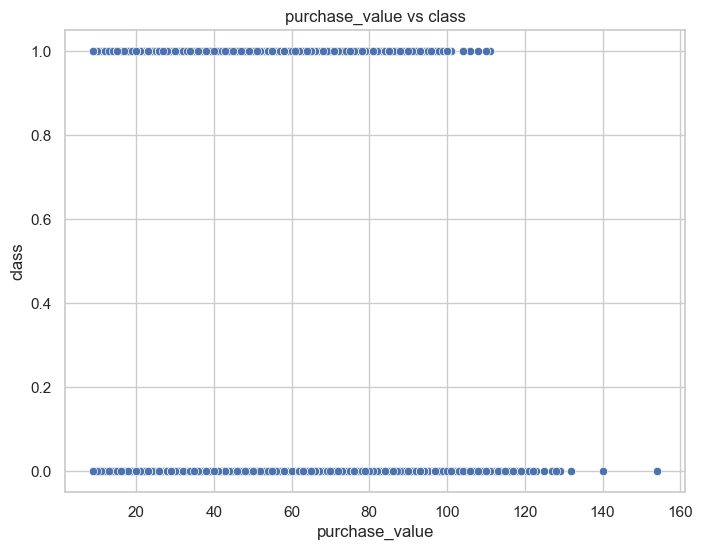


Analysis for: device_id vs class

Analysis for: source vs class

Analysis for: browser vs class

Analysis for: sex vs class

Analysis for: age vs class

Correlation with class: 0.01


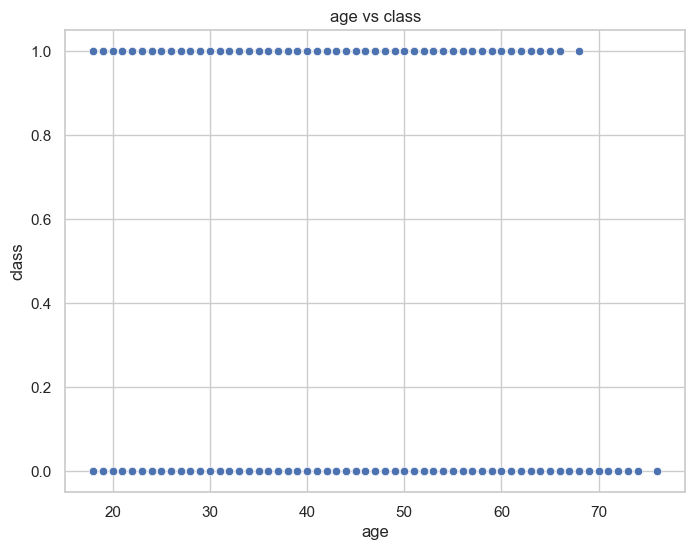


Analysis for: ip_address vs class

Correlation with class: -0.01


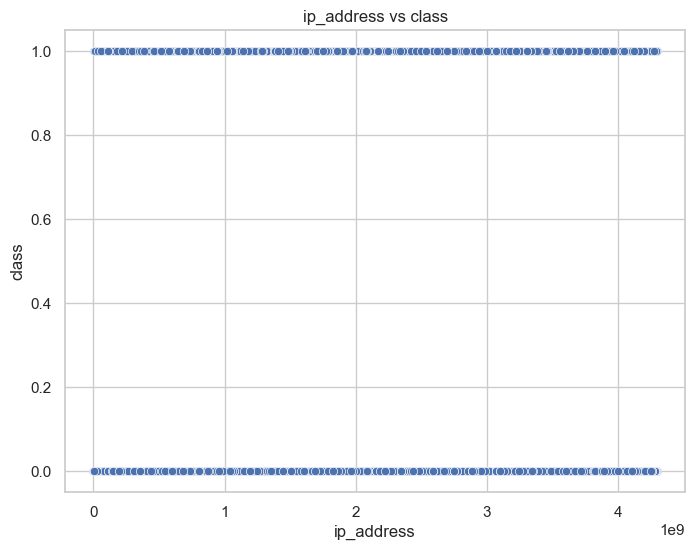

In [6]:
# Perform bivariate analysis with 'class' as target
print("\n\nBIVARIATE ANALYSIS RESULTS")
bi_results = bivariate_analysis1(df_fraud, target_col='class')